# **Methylation Biomarkers for Predicting Cancer**

## **Deep Learning Approaches to Cancer Classification**

**Author:** Meg Hutch

**Date:** January 26, 2020

**Objective:** Use neural networks to classify colon, esophagus, liver, and stomach cancer patients and healthy subjects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

**Import Training, Testing, and Principal component data**

In [2]:
# Training set
mcTrain = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTrain.csv')
# Testing set
mcTest = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTest.csv')
# All Principal Components
principal_Df_ALL = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/principalDF_ALL.csv')
# Principal Components that make up 90% of the variance of the training set
genesTrain_transformed_90 = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTrain_transformed_90.csv')
# Principal Components projected onto the test set
genesTest_transformed_90 = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTest_transformed_90.csv')

In [3]:
mcTrain.head()
genesTrain_transformed_90.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52
0,SEQF2183,-144.158481,-27.480976,-7.781986,13.734680,27.506510,-16.649830,28.168318,-14.486793,0.559815,...,2.378400,-0.830927,4.014084,-1.475105,9.307659,-11.167497,-1.389498,-8.699041,-1.389689,-0.797106
1,SEQF2054,-62.711787,4.444954,11.411418,13.286470,-1.257518,6.414986,4.740393,0.146344,-0.367381,...,1.831946,0.499020,-2.449973,-1.474650,-3.769866,-0.674254,-0.798050,1.165255,-4.197586,-7.707251
2,SEQF2489,35.480599,23.448786,3.856209,11.685045,41.517738,-17.683351,-3.424532,-2.065137,12.988382,...,5.837145,-11.558882,-4.847770,-0.577521,5.357721,-2.457032,1.825354,0.832253,-1.805568,-5.711660
3,SEQF2158,32.712541,-20.317249,0.630302,-14.809538,-0.058078,-4.138992,11.249006,-1.469514,3.027478,...,2.596779,-2.031014,1.287617,-0.625744,1.294597,0.641198,0.610230,2.953519,3.034539,-0.379165
4,SEQF2348,17.158915,-20.655900,1.473698,-5.535790,0.105691,-2.992127,5.757142,-1.167972,-5.081490,...,1.795425,1.149464,1.076880,4.131549,-0.617409,1.387274,-4.101220,-1.765308,2.756626,-4.772480


# **Pre-Process Data**

In [4]:
# remove genetic data from the mcTrain dataset
mcTrain = mcTrain[['seq_num','diagnosis', 'dilute_library_concentration', 'age', 'gender']]

# do the same for the testing set
mcTest = mcTest[['seq_num','diagnosis', 'dilute_library_concentration', 'age', 'gender']]

In [5]:
# rename the first column name of the PC dataframes
genesTrain_transformed_90.rename(columns={'Unnamed: 0':'seq_num'}, inplace=True)
genesTest_transformed_90.rename(columns={'Unnamed: 0':'seq_num'}, inplace=True)

In [6]:
# merge PCs with clinical/phenotypic data
mcTrain = pd.merge(mcTrain, genesTrain_transformed_90, how="left", on="seq_num") 
mcTest = pd.merge(mcTest, genesTest_transformed_90, how="left", on="seq_num") 

**Shuffle the training and test sets**

Currently, all disease states are in order - we don't want to feed to the network in order!

In [7]:
import random
random.seed(222020)
mcTrain = mcTrain.sample(frac=1, axis = 0).reset_index(drop=True) # frac = 1 returns all rows in random order
mcTest = mcTest.sample(frac=1, axis = 0).reset_index(drop=True)

**Create a new numeric index and drop seq_num**
For future code we want the index to be numeric

In [8]:
# Create new ids
mcTrain['id'] = mcTrain.index + 1
mcTest['id'] = mcTest.index + 239

# Drop num_seq
mcTrain= mcTrain.drop(columns=["seq_num"])
mcTest = mcTest.drop(columns=["seq_num"])

**Remove Labels (Diagnosis) from the datasets**

In [9]:
mcTrain_x = mcTrain.drop(columns=["diagnosis"])
mcTest_x = mcTest.drop(columns=["diagnosis"])

**Create Labeled Datasets**

In [10]:
mcTrain_y = mcTrain[['id','diagnosis']]
mcTest_y = mcTest[['id','diagnosis']]

In [11]:
# Examine the unique target variables
mcTrain_y.diagnosis.unique()

array(['STAD', 'ESCA', 'HCC', 'CRC', 'HEA'], dtype=object)

In [12]:
# Replace each outcome target with numerical value
mcTrain_y = mcTrain_y.replace('HEA', 0)
mcTrain_y = mcTrain_y.replace('CRC', 1)
mcTrain_y = mcTrain_y.replace('ESCA', 2)
mcTrain_y = mcTrain_y.replace('HCC', 3)
mcTrain_y = mcTrain_y.replace('STAD', 4)

mcTest_y = mcTest_y.replace('HEA', 0)
mcTest_y = mcTest_y.replace('CRC', 1)
mcTest_y = mcTest_y.replace('ESCA', 2)
mcTest_y = mcTest_y.replace('HCC', 3)
mcTest_y = mcTest_y.replace('STAD', 4)

**Convert seq_num id to index**

In [13]:
mcTrain_x = mcTrain_x.set_index('id')
mcTrain_y = mcTrain_y.set_index('id')

mcTest_x = mcTest_x.set_index('id')
mcTest_y = mcTest_y.set_index('id')

**Examine Distribution of Variables**

Text(0, 0.5, 'Frequency')

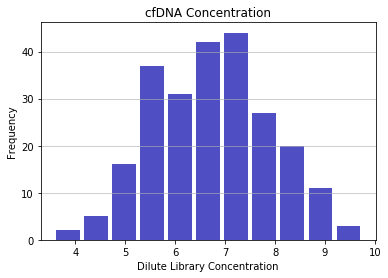

In [14]:
# cfDNA Concentration
plt.hist(mcTrain_x.dilute_library_concentration, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title('cfDNA Concentration')
plt.xlabel('Dilute Library Concentration')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

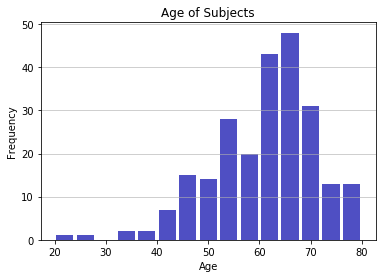

In [15]:
# Age
plt.hist(mcTrain_x.age, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title('Age of Subjects')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

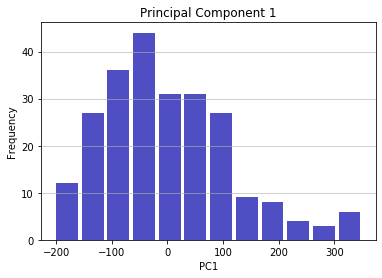

In [16]:
# principal component
plt.hist(mcTrain_x.pc1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title('Principal Component 1')
plt.xlabel('PC1')
plt.ylabel('Frequency')

**Normalize Data**

From my reading, it seems that normalization, as opposed to standardization, is the more optimal approach when data is not normally distributed. 

Normalization will rescale our values into range of [0,1]. We need to normalize both the training and test sets

In [17]:
from sklearn.preprocessing import MinMaxScaler

# The normalization function to be performed will convert dataframe into array, for this reason we'll have to convert it back
# Thus, need to store columns and index
# select all columns
cols = list(mcTrain_x.columns.values)
index_train = list(mcTrain_x.index)
index_test = list(mcTest_x.index)

# Normalize data
scaler = MinMaxScaler()
mcTrain_x = scaler.fit_transform(mcTrain_x)
mcTest_x = scaler.fit_transform(mcTest_x)

# Convert back to dataframe
mcTrain_x = pd.DataFrame(mcTrain_x, columns = cols, index = index_train)
mcTest_x = pd.DataFrame(mcTest_x, columns = cols, index = index_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Construct & Test Neural Network

In [18]:
# Import PyTorch packages
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
# define list for results
results_ls = []

# Where we will store correct/incorrect classifications
incorrect_ls = []
correct_ls = []

# Leave-one-out-cross-fold validation
for index in range (0,238):

    # X - features
    mcTrain_xy = mcTrain_x.drop(mcTrain_x.index[index])
    mcTrain_xy = np.array(mcTrain_xy, dtype = "float32")
    
    # y - target/outputs
    mcTrain_yz = mcTrain_y.drop(mcTrain_y.index[index]) 
    mcTrain_yz = np.array(mcTrain_yz, dtype = "float32")
    
    # reformatt into tensors
    xb = torch.from_numpy(mcTrain_xy)
    yb = torch.from_numpy(mcTrain_yz)
    
    # squeeze 
    yb = yb.squeeze(1) # function is used when we want to remove single-dimensional entries from the shape of an array.
    
    # add the equivalent training_test set
    mcTrain_test_x = mcTrain_x.iloc[[index]]
    mcTrain_test_x = np.array(mcTrain_test_x, dtype = "float32")
            
    # y - targets/outputs
    mcTrain_test_y = mcTrain_y.iloc[[index]]
    mcTrain_test_y = np.array(mcTrain_test_y, dtype = "float32")
        
    # Convert arrays into tensors
    test_xb = torch.from_numpy(mcTrain_test_x)
    test_yb = torch.from_numpy(mcTrain_test_y)
    
    # append all dfs
    #df_train_x.append(xb)
    #df_train_y.append(yb)
    
    # Define the batchsize
    batch_size = 32

    # Combine the arrays
    trainloader = TensorDataset(xb, yb)
    
    # Training Loader
    trainloader = DataLoader(trainloader, batch_size, shuffle=True)
    
    # Build Model
    # Define the model with hidden layers
    model = nn.Sequential(nn.Linear(55, 25),
                          nn.ReLU(),
                          nn.Linear(25, 5))
                      
                      
    # Set optimizer and learning rate
    #optimizer = optim.SGD(model.parameters(), lr=0.003)

    # Could also use Adam optimizer; similar to stochastic gradient descent, but uses momentum which can speed up the actual fitting process, and it also adjusts the learning rate for each of the individual parameters in the model
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    # loss function
    criterion = nn.CrossEntropyLoss() #don't use with softmax or sigmoid- PyTorch manual indicates "This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class."

    
    # Set epochs
    epochs = 150
    for e in range(epochs):
        running_loss = 0
        
        for xb, yb in trainloader:
            # Training pass
            output = model.forward(xb)
            loss = criterion(output, yb.long()) # Loss calculated from the output compared to the labels  
            # clear gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item() # loss.item() gets the scalar value held in the loss. Running_loss = 0, 
            # += notation, says "Add a value and the variable and assigns the result to that variable." So, adds the running_loss (0) with loss.item and assigns to running_loss
        else:
            print("Epoch {}/{}, Training loss: {:.5f}".format(e+1, epochs, running_loss/len(trainloader)))

    #for index in range (0,3):
    # Apply the model to the whole testing dataset
    ps = model(test_xb)
        
    #print('Probabilities', ps[:10])

    # Obtain the top probability
    top_p, top_class = ps.topk(1, dim=1)
    #print('true vals', test_yb[:10])

    #print(ps, top_p, top_class) # ps: shows us the model predictions for each of the 5 classes
    # top_p: identifies the max of the classes
    # top_class: gives us the 0-4 classification
                
    # Drop the grad 
    top_p = top_p.detach().numpy()
    top_class = top_class.detach().numpy()

    # convert to integers
    top_class = top_class.astype(np.int)
    test_yb = test_yb.numpy()
    test_yb = test_yb.astype(np.int)
    #print('top class', top_class[:10])
    print('prediction:', top_class)
    print('true:', test_yb)
                
# compare top_class to test_yb
    #for index in range(0,3):
    if top_class == test_yb:                
        results = 1 # prediction and true value are equal
    else: 
        results = 0
    
    # Create if-else statements to identify which classes are being classified correctly/incorrectly
    if results == 0:
        incorrect = test_yb
    else: 
        incorrect = np.array([[999]], dtype=int)
        
    if results == 1:
        correct = test_yb
    else: 
        correct = np.array([[999]], dtype=int)
    print('Results:', results)
    
    results_ls.append(results)
    incorrect_ls.append(incorrect)
    correct_ls.append(correct)
    #results_ls.append(results_ls)
    print(results_ls)  

Epoch 1/150, Training loss: 1.58900
Epoch 2/150, Training loss: 1.56454
Epoch 3/150, Training loss: 1.55186
Epoch 4/150, Training loss: 1.54092
Epoch 5/150, Training loss: 1.53449
Epoch 6/150, Training loss: 1.53045
Epoch 7/150, Training loss: 1.52696
Epoch 8/150, Training loss: 1.51082
Epoch 9/150, Training loss: 1.49654
Epoch 10/150, Training loss: 1.48711
Epoch 11/150, Training loss: 1.48672
Epoch 12/150, Training loss: 1.47589
Epoch 13/150, Training loss: 1.45396
Epoch 14/150, Training loss: 1.45324
Epoch 15/150, Training loss: 1.43659
Epoch 16/150, Training loss: 1.42797
Epoch 17/150, Training loss: 1.39505
Epoch 18/150, Training loss: 1.36896
Epoch 19/150, Training loss: 1.36070
Epoch 20/150, Training loss: 1.34463
Epoch 21/150, Training loss: 1.33454
Epoch 22/150, Training loss: 1.31396
Epoch 23/150, Training loss: 1.29451
Epoch 24/150, Training loss: 1.27708
Epoch 25/150, Training loss: 1.26182
Epoch 26/150, Training loss: 1.22877
Epoch 27/150, Training loss: 1.23834
Epoch 28/1

# **Determine LOOCV mean error**

In [25]:
percent_correct = sum(results_ls)
percent_correct = percent_correct/len(mcTrain)*100
print('Percent Correct', percent_correct)

Percent Correct 55.88235294117647


# **Incorrect Predictions**

In [26]:
## Remove the correct elements from the ls to faciliate transforming this list into a dataframe
# First, concatenate all incorrect list elements and format into dataframe
incorrect_ls = np.concatenate(incorrect_ls)
incorrect_ls = pd.DataFrame(incorrect_ls)
incorrect_ls.columns = ['diagnosis']
incorrect_ls = incorrect_ls[incorrect_ls.diagnosis != 999] # 999 are the results that were correct - we remove these

# Count number of incorrect predictions by diagnosis
incorrect_pred = incorrect_ls.groupby(['diagnosis']).size()
incorrect_pred = pd.DataFrame(incorrect_pred)
incorrect_pred.columns = ['Count']

# Convert the index to the first column and change the numebr to categorical variables
incorrect_pred.reset_index(level=0, inplace=True)
incorrect_pred['diagnosis'] = incorrect_pred['diagnosis'].map({0: 'HEA', 1: 'CRC', 2: 'ESCA', 3: 'HCC', 4: 'STAD'})

# Add a column with the number of cases in each class
class_size = mcTrain.groupby(['diagnosis']).size()
class_size = pd.DataFrame(class_size)
class_size.columns = ['Sample_n']

# bind class_size to the pred df diagnoses
incorrect_pred = pd.merge(incorrect_pred, class_size, how="left", on="diagnosis") 

# Calculate the percent error for each class
incorrect_pred['Count_Perc_Incorrect'] = incorrect_pred['Count']/incorrect_pred['Sample_n']
incorrect_pred['Count_Perc_Incorrect'] = incorrect_pred['Count_Perc_Incorrect'].multiply(100)

print(incorrect_pred)

  diagnosis  Count  Sample_n  Count_Perc_Incorrect
0       HEA     12        69             17.391304
1       CRC     28        53             52.830189
2      ESCA     24        28             85.714286
3       HCC     16        58             27.586207
4      STAD     25        30             83.333333


# **Correct Predictions**

In [27]:
## Remove the incorrect elements from the ls to faciliate transforming this list into a dataframe
# First, concatenate all incorrect list elements and format into dataframe
correct_ls = np.concatenate(correct_ls)
correct_ls = pd.DataFrame(correct_ls)
correct_ls.columns = ['diagnosis']
correct_ls = correct_ls[correct_ls.diagnosis != 999] # 999 are the results that were incorrect - we remove these

# Count number of correct predictions by diagnosis
correct_pred = correct_ls.groupby(['diagnosis']).size()
correct_pred = pd.DataFrame(correct_pred)
correct_pred.columns = ['Count']

# Convert the index to the first column and change the numebr to categorical variables
correct_pred.reset_index(level=0, inplace=True)
correct_pred['diagnosis'] = correct_pred['diagnosis'].map({0: 'HEA', 1: 'CRC', 2: 'ESCA', 3: 'HCC', 4: 'STAD'})

# Add a column with the number of cases in each class
class_size = mcTrain.groupby(['diagnosis']).size()
class_size = pd.DataFrame(class_size)
class_size.columns = ['Sample_n']

# bind class_size to the pred df diagnoses
correct_pred = pd.merge(correct_pred, class_size, how="left", on="diagnosis") 

# Calculate the percent correct for each class
correct_pred['Count_Perc_Correct'] = correct_pred['Count']/correct_pred['Sample_n']
correct_pred['Count_Perc_Correct'] = correct_pred['Count_Perc_Correct'].multiply(100)

print(correct_pred)

  diagnosis  Count  Sample_n  Count_Perc_Correct
0       HEA     57        69           82.608696
1       CRC     25        53           47.169811
2      ESCA      4        28           14.285714
3       HCC     42        58           72.413793
4      STAD      5        30           16.666667


**Monday Feb 3:**

* Standardize all data? - Completed!
* Determine which samples are being misclassified? - Completed!
* Review/clean code. review for loop mechanics
* Start running tests 
* Create plot with each of the running loss to see how many epochs until converge? Different color for each test?
* Develop grid search for hyperparameter tuning?